In [1]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
import sklearn
from sklearn import metrics

In [2]:
alphabet = "VINSALELLNEVGIEGLTTRPLAQKLGVEQPTLYWHVKNKRALL-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

In [19]:
states

45

In [3]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''converts list of sequences to numpy array'''
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  return np.array(msa)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  # pairwise identity
  msa_sm = (msa[:,None,:]==msa).sum(2)/ncol

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

In [12]:
# parse fasta
names, seqs = parse_fasta("C:/Users/niloo/OneDrive/Desktop/prot-struct-pred-master/data/PF00440.fasta")

# convert seqs to array
msa = mk_msa(seqs)

# remove positions with more than > 50% gaps
#msa, msa_idx = filt_gaps(msa,0.5)

# compute effective weight for each sequence
#msa_eff = get_eff(msa,0.8)

# compute effective number of sequences
#neff = np.sum(msa_eff)

# store shape of msa
nrow = msa.shape[0] # num rows (sequences)
ncol = msa.shape[1] # num cols (positions)
nrow
ncol

147

In [13]:
from scipy.spatial.distance import *

def Compute_True_Frequencies(align,M,N,q,theta,):
    # computes reweighted frequency counts
    
    W=np.ones(M,dtype=np.float64)
    if (theta > 0.0):
        W=(1.0 / (1 + sum(squareform(pdist(align,'hamm') < theta))))
    Meff=sum(W)
    Pij_true=np.zeros((N,N,q,q),dtype=np.float64)
    Pi_true=np.zeros((N,q),dtype=np.float64)
    for j in range(M):
        for i in range(N):
            Pi_true[i,align[j,i]]=Pi_true[i,align[j,i]] + W[j]
    
    Pi_true=Pi_true / Meff
    for l in range(M):
        for i in range(N):
            for j in range(i+1,N):
                Pij_true[i,j,align[l,i],align[l,j]] = Pij_true[i,j,align[l,i],align[l,j]] + W[l]
                Pij_true[j,i,align[l,j],align[l,i]] = Pij_true[i,j,align[l,i],align[l,j]]
    Pij_true = Pij_true/Meff
    scra=np.eye(q,q)
    for i in range(N):
        for alpha in range(q):
            for beta in range(q):
                Pij_true[i,i,alpha,beta]=np.dot(Pi_true[i,alpha],scra[alpha,beta])
    
    return Pij_true,Pi_true,Meff

In [14]:
def dca(msa):
  msa = msa # align

  ncol = msa.shape[1] #N
  nrow = msa.shape[0] #M
  
  psedo_weight=0.2
  psedo_weight_i = psedo_weight / states
  psedo_weight_ij = psedo_weight / states / states 
  
  theta=0.2
  
  pair_pssm,pssm, Meff=Compute_True_Frequencies(msa,nrow,ncol,states,theta)
  
  
  
  Pi = (1.0 - psedo_weight) * pssm + psedo_weight_i * np.ones((ncol,states))  
  
  Pij = (1.0 - psedo_weight) * pair_pssm + psedo_weight_ij * np.ones((ncol,ncol,states,states)) 
  for i in range(ncol):
    Pij[i,i,:,:] = (1.0 - psedo_weight) * pair_pssm[i,i,:,:] + psedo_weight_i * np.eye(states)
    
  C = Pij - Pi[:,None,:,None] * Pi[None,:,None,:]
  C = C[:,:,0:states-1,0:states-1]
  C = C.transpose([0,2,1,3])
  C = np.reshape(C,(ncol*(states-1),ncol*(states-1)))
  invC = np.linalg.inv(C)

  H = -np.sum(pssm * np.log(pssm+1e-8),1)
  MI_true = H[None,:]+ H[:,None] + np.sum(pair_pssm * np.log(pair_pssm+1e-8),(2,3))
  
  W_mf = np.ones((ncol,states,ncol,states))
  W_mf[:,0:(states-1),:,0:(states-1)] = np.exp(-invC.reshape(ncol,(states-1),ncol,(states-1)))
  W_mf = np.transpose(W_mf,[0,2,1,3])
  
  DI = np.zeros((ncol,ncol))
  epsilon = 1e-4
  tiny = 1e-100
  for i in range(ncol-1):
    for j in range(i+1,ncol):
      diff = 1.0
      mui = np.ones(states) / states
      muj = np.ones(states) / states
      
      pi = Pi[i,:]
      pj = Pi[j,:]
      while (diff>epsilon):  
        
        newi = pi / np.dot(muj, W_mf[i,j,:,:].T)
        newi = newi / sum(newi)
        
        newj = pj / np.dot(mui, W_mf[i,j,:,:])
        newj = newj / sum(newj)
        
        diff = max(max(abs(newi - mui)),max(abs(newj - muj)))
        
        mui = np.copy(newi)
        muj = np.copy(newj) 
        
      Pdir = W_mf[i,j,:,:] * (np.tensordot(mui,muj,0))            
      Pdir = Pdir / sum(sum(Pdir))
      
      Pfac = np.tensordot(Pi[i,:].T,Pi[j,:],0)
      logpp = np.log((Pdir+tiny) / (Pfac+tiny))
      DI[i,j] = np.trace(np.dot(Pdir.T,logpp))
  
  return MI_true,DI

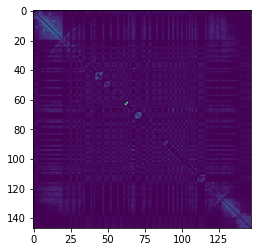

In [15]:
MI_true,DI = dca(msa)
print
plt.imshow(DI+DI.T)
plt.grid(False)
plt.show()

In [18]:
mi = DI+DI.T

contacts = np.zeros((147,147))
for i in range(147):
    for j in range(147):
        if mi[i,j] >= 0.05:
            contacts[i,j] = 1
        else:
            contacts[i,j] = 0

with open('C:/Users/niloo/OneDrive/Desktop/dca.txt','wb') as f:
    for line in contacts:
        np.savetxt(f, line, fmt='%.2f')